# Step 7: Model Selection

In this step we train several ML models with the latest version of the Pipeline we defined up to Step 6.

In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    ordered_col = ['Age range']

    categorical_cols = ['Type', 'Gender', 'Officer-defined ethnicity', 'Object of search']

    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    # Define ordered pipeline
    ordered_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[['under 10', '10-17', '18-24', '25-34', 'over 34']] ,handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ])
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('ord', ordered_pipe, ordered_col),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

In [4]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Age range', 'Type', 'Gender', 'Officer-defined ethnicity', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Age range,Type,Gender,Officer-defined ethnicity,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.0,0.826087,0.666667,0.5,0.54514,0.503851,0.499512,0.55516,0.0,0.584645,0.698278
1,0.0,1.0,0.73913,1.0,1.0,0.484365,0.503851,0.487024,0.55516,0.0,0.252933,0.739332
2,0.333333,0.0,0.652174,0.333333,0.5,0.484365,0.503851,0.499512,0.55516,0.0,0.511023,0.65343
3,0.0,0.0,0.391304,0.333333,0.5,0.484365,0.503851,0.499512,0.55516,0.0,0.471838,0.539571
4,0.333333,0.0,0.73913,0.166667,0.75,0.54514,0.503851,0.499512,0.55516,0.0,0.50235,0.695199
...,...,...,...,...,...,...,...,...,...,...,...,...
98769,0.333333,1.0,0.043478,0.5,0.75,0.54514,0.503851,0.499512,0.55516,0.0,0.063275,0.40027
98770,0.0,1.0,0.565217,0.166667,0.75,0.484365,0.503851,0.513135,0.55516,0.0,0.27568,0.777481
98771,1.0,1.0,0.217391,0.333333,1.0,0.54514,0.503851,0.499512,0.55516,0.0,0.464807,0.526711
98772,1.0,1.0,0.695652,0.833333,0.25,0.484365,0.503851,0.499512,0.331967,0.0,0.659453,0.522612


# Check All Models

In [5]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56202155 0.56313424 0.56422605 0.56129552 0.56429156]


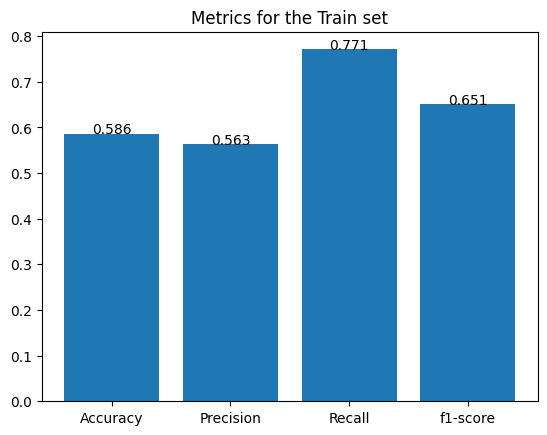

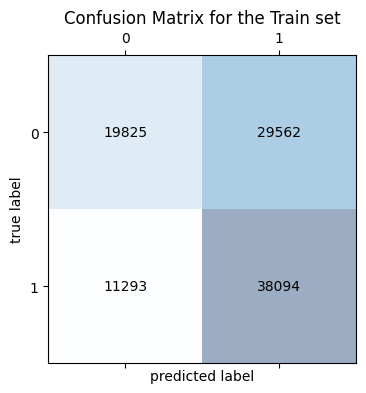

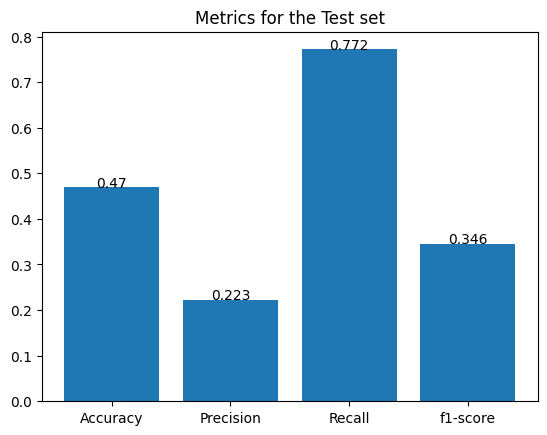

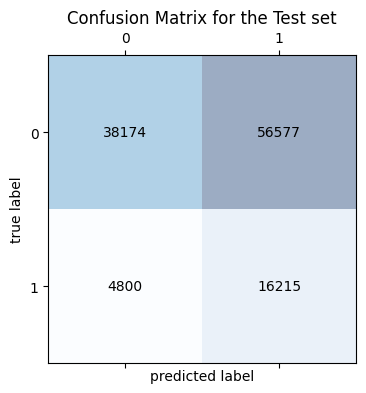

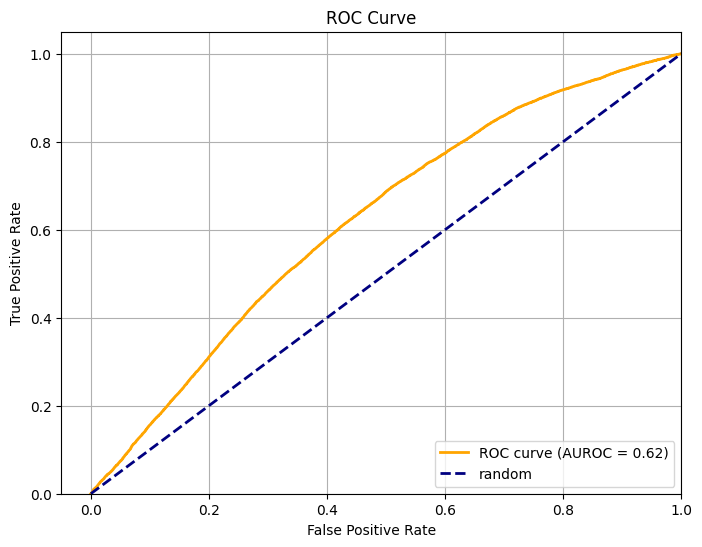

In [6]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

Recall requirement: (False, 0.7715917201998572)


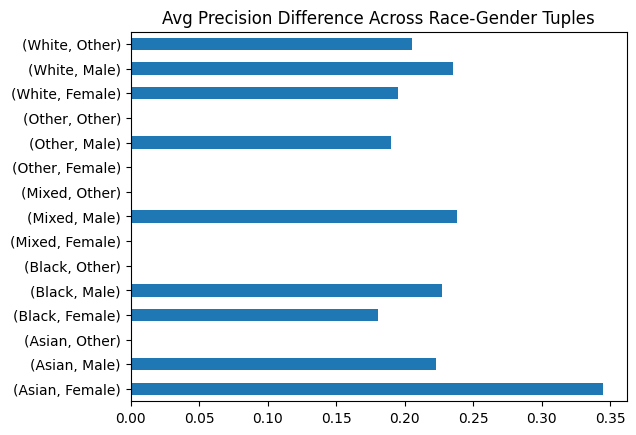

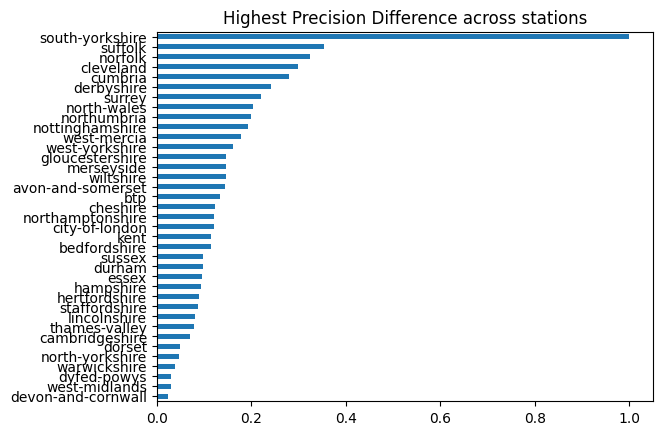

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23527259982187357, ('White', 'Female'): 0.19534137492598325, ('White', 'Other'): 0.20495495495495497, ('Black', 'Male'): 0.22691930519257575, ('Black', 'Female'): 0.18053630809048765, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.2226211975217907, ('Asian', 'Female'): 0.34472934472934474, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.23835688802291852, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.18994532734018718, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 31
Num good departments: 6
avg diff: 0.16178837837837837


In [7]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [8]:
model = LogisticRegression()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

[0.55907251 0.55832373 0.55748468 0.55473138 0.56105855]


/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


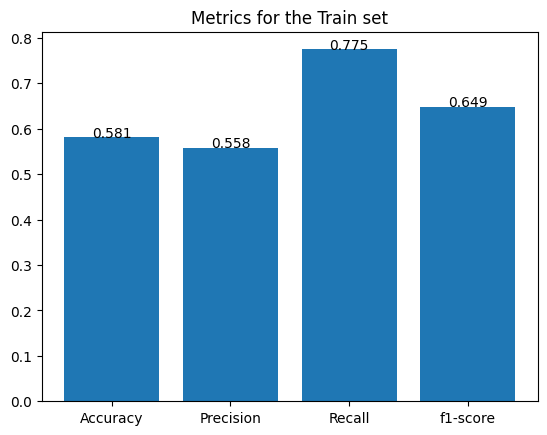

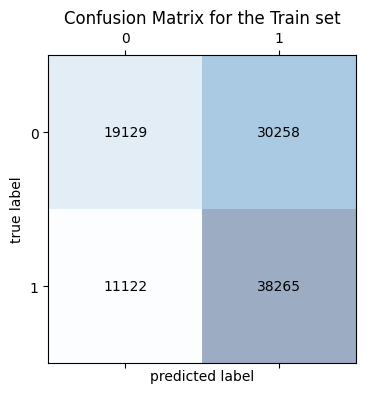

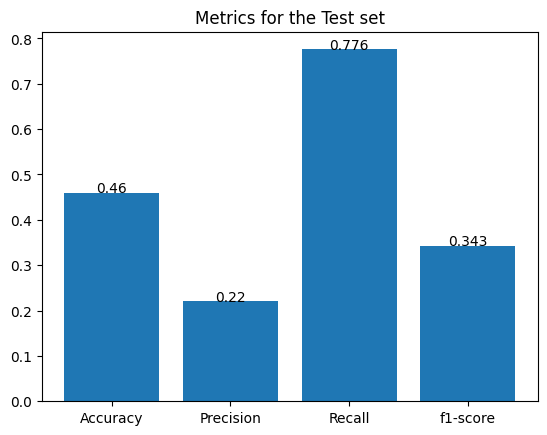

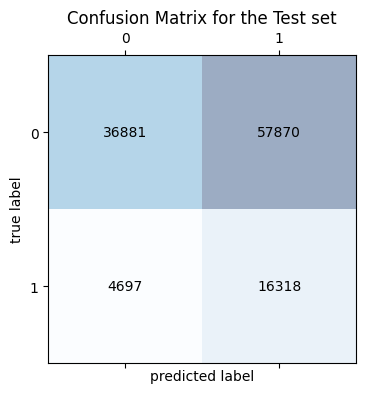

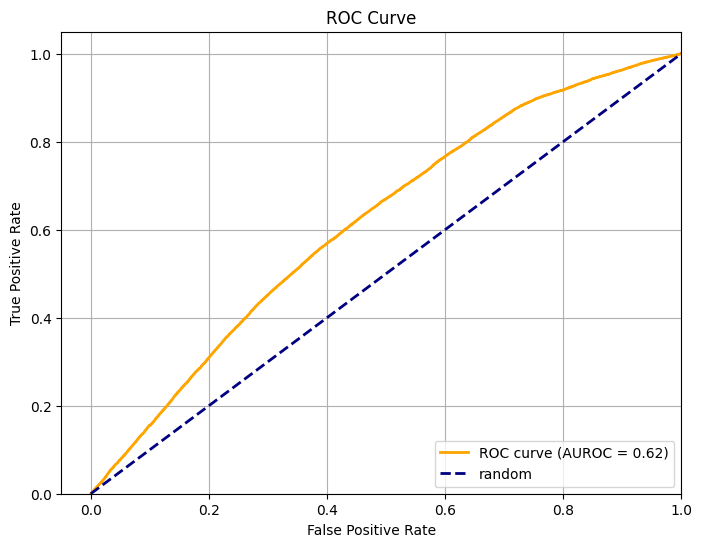

In [9]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

Recall requirement: (False, 0.776492981203902)


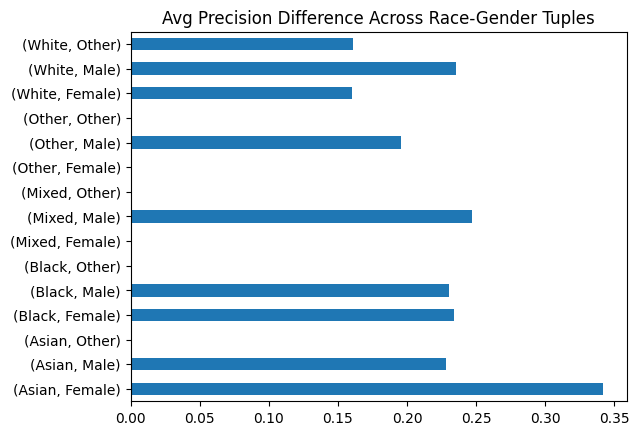

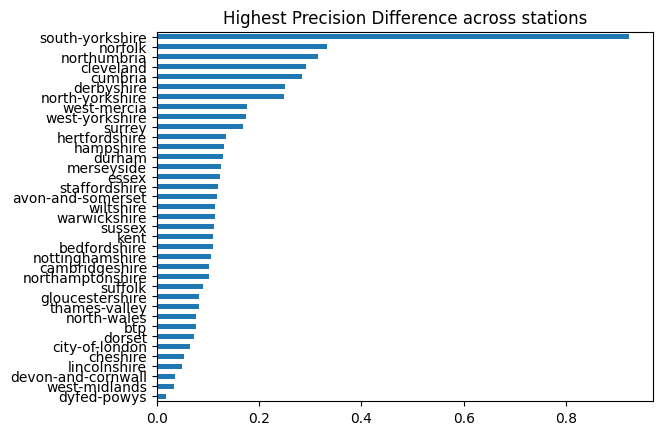

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.2355100902537413, ('White', 'Female'): 0.16012795170197439, ('White', 'Other'): 0.16064516129032258, ('Black', 'Male'): 0.23011737305520252, ('Black', 'Female'): 0.2338266838266838, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.22803769906987267, ('Asian', 'Female'): 0.3419642857142857, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.24720279773962087, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.1959323305990528, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 33
Num good departments: 4
avg diff: 0.1529791891891892


In [10]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [11]:
model = DecisionTreeClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56029085 0.56344019 0.56682786 0.56400954 0.566201  ]


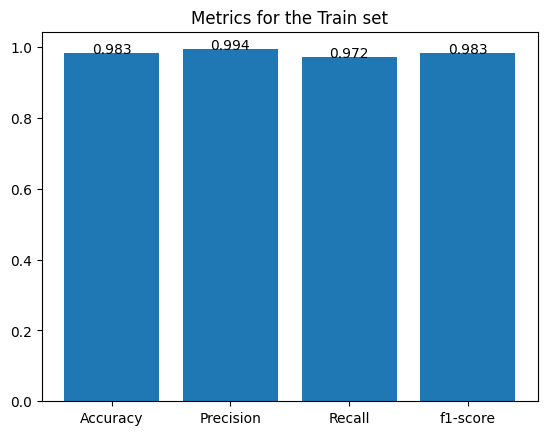

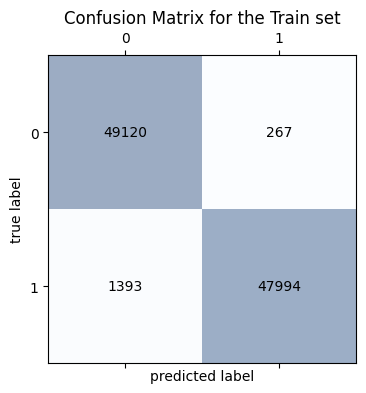

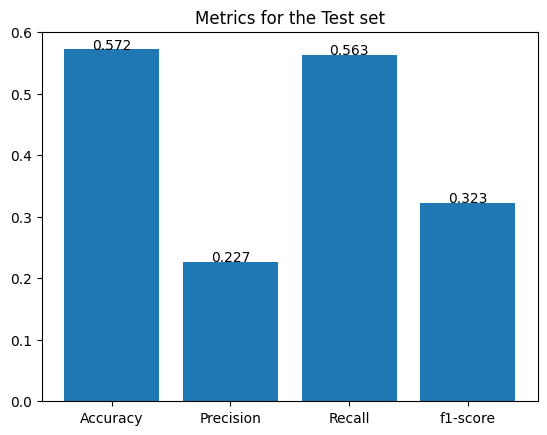

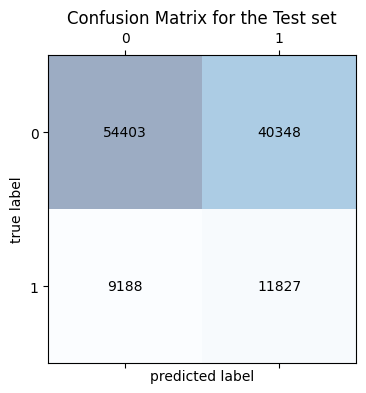

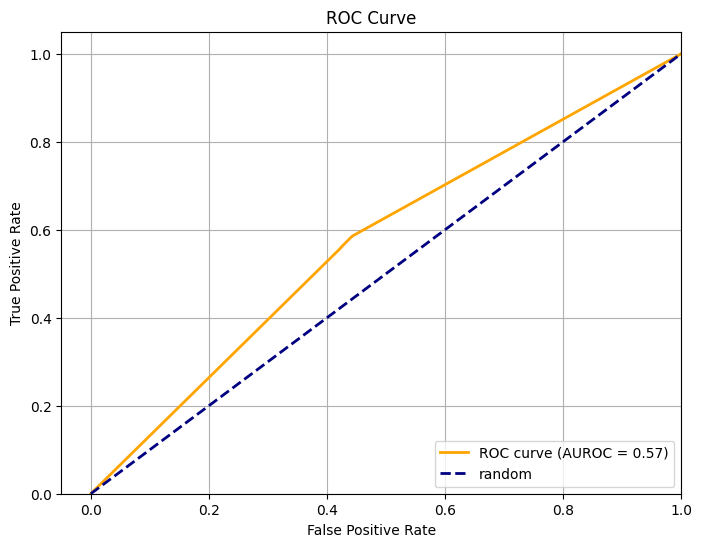

In [12]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

Recall requirement: (False, 0.5627884844158935)


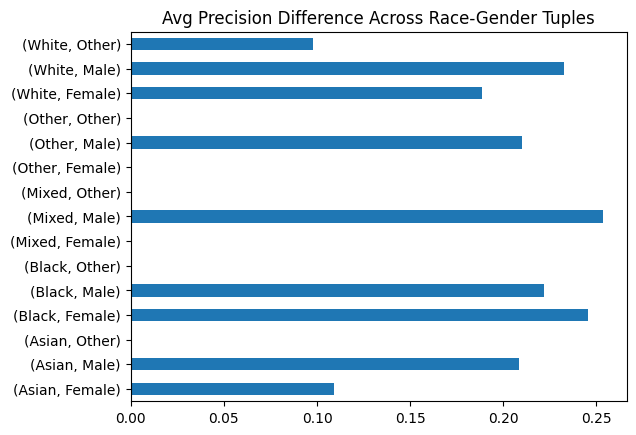

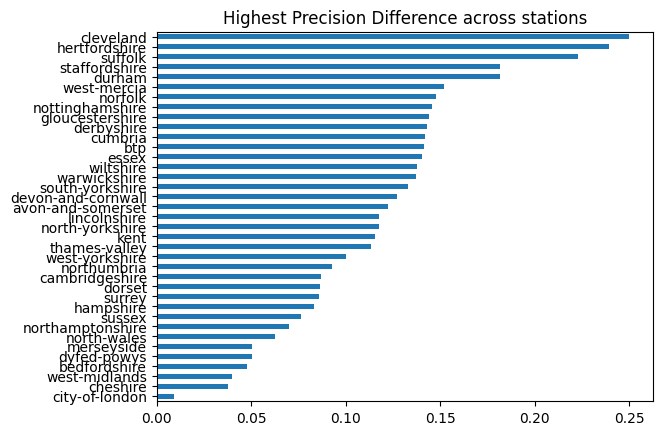

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23280092402264166, ('White', 'Female'): 0.18860179182767992, ('White', 'Other'): 0.09808612440191387, ('Black', 'Male'): 0.2220993828986466, ('Black', 'Female'): 0.2453827126221896, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.20869137791977882, ('Asian', 'Female'): 0.10894660894660894, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2535788884496378, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.20995750823076498, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 33
Num good departments: 4
avg diff: 0.11710945945945946


In [13]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [14]:
model = LinearSVC()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.55859603 0.5583603  0.55670776 0.55507745 0.56088425]


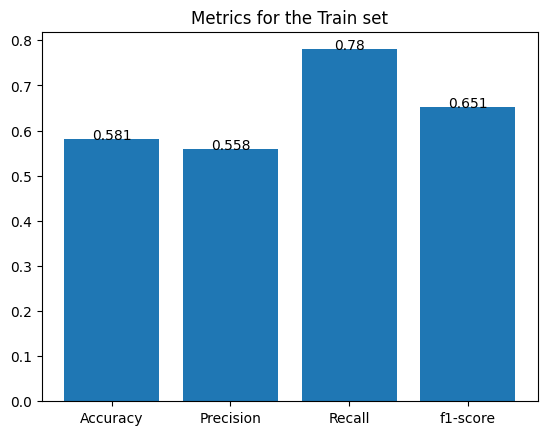

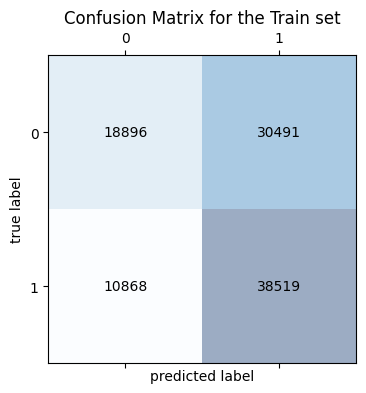

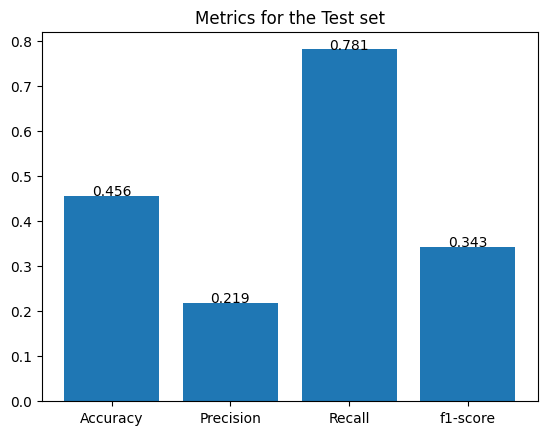

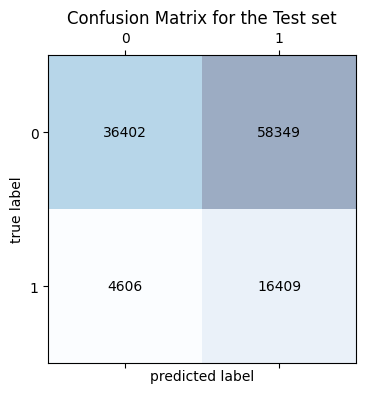

In [15]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
# y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

# aux_functions.plot_roc_curve(y_test, y_hat)

Recall requirement: (False, 0.7808232215084463)


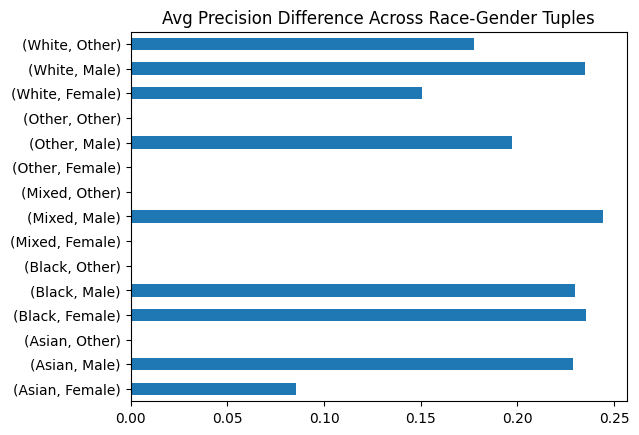

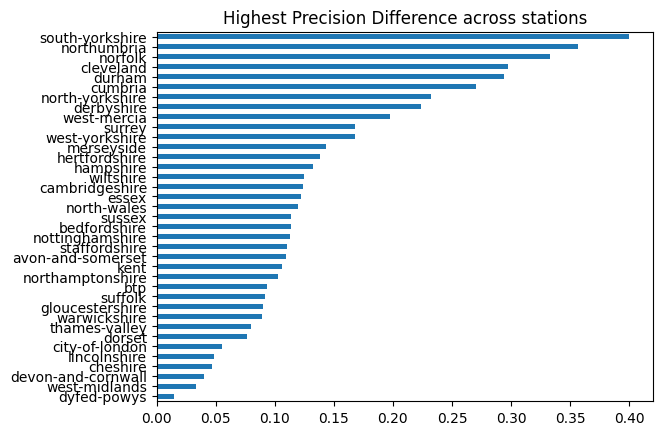

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23479037404262354, ('White', 'Female'): 0.15081325512290955, ('White', 'Other'): 0.1774193548387097, ('Black', 'Male'): 0.2298075620367234, ('Black', 'Female'): 0.23572326687276063, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.22868005651810197, ('Asian', 'Female'): 0.08547008547008547, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.24436636961972472, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.19742864591870907, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 32
Num good departments: 5
avg diff: 0.14518540540540542


In [16]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [17]:

model = KNeighborsClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56462787 0.56144839 0.56526429 0.56450498 0.56401723]


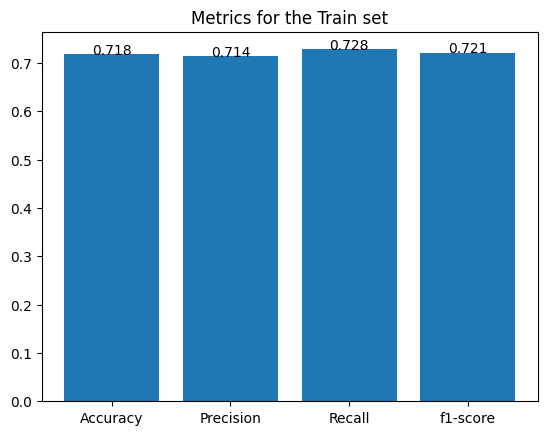

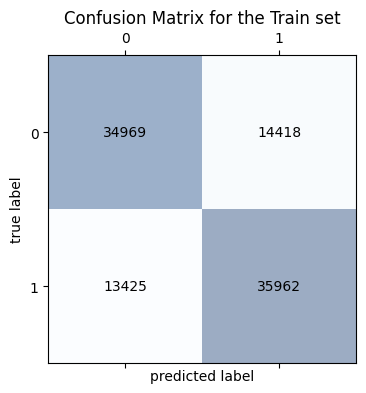

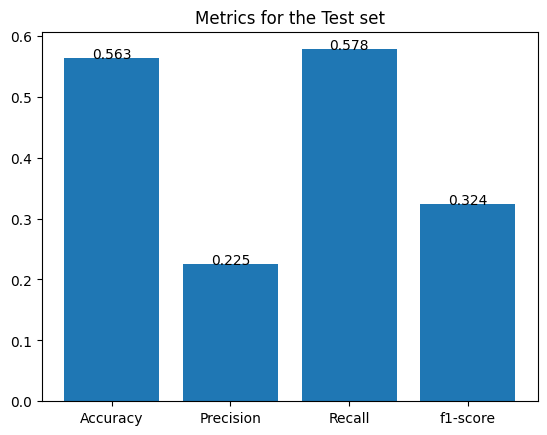

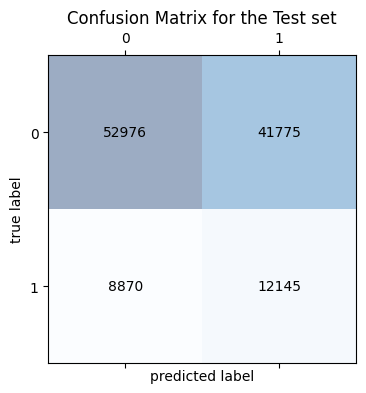

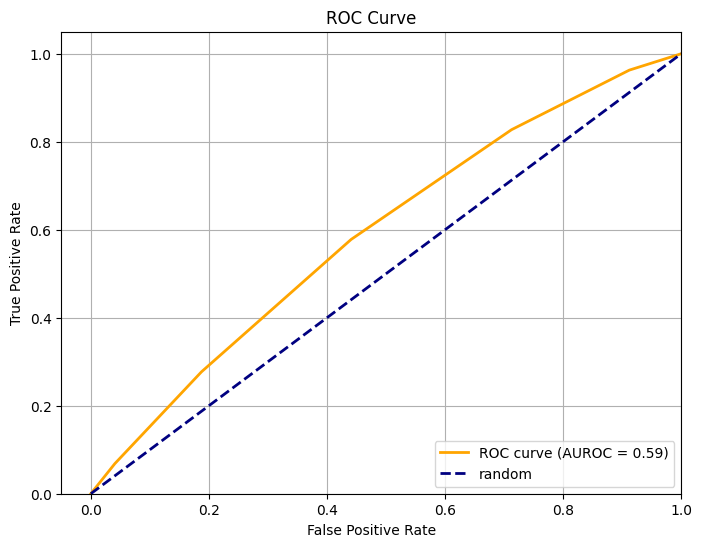

In [18]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

Recall requirement: (False, 0.5779205329526529)


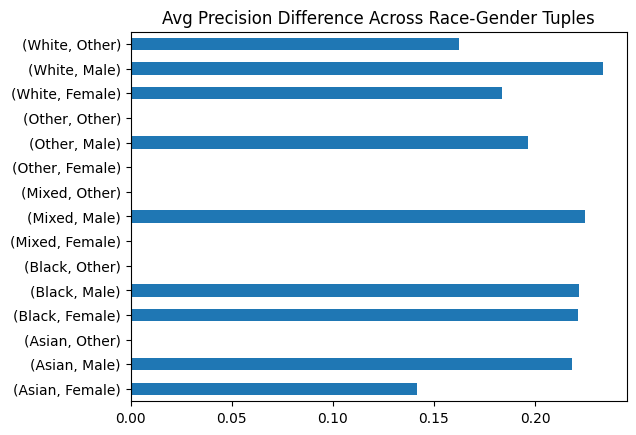

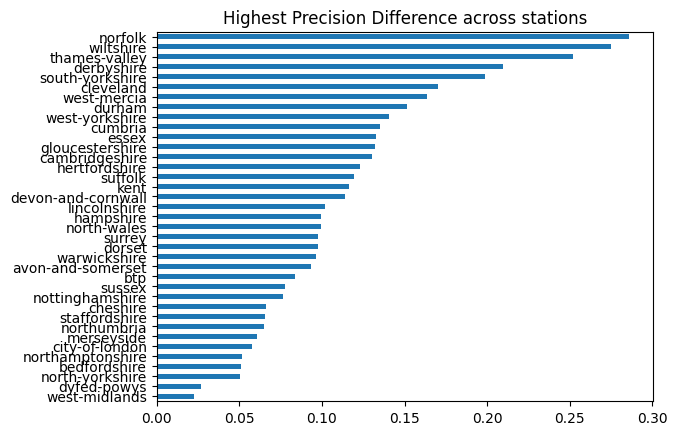

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23366330453301218, ('White', 'Female'): 0.18389951418037134, ('White', 'Other'): 0.16230936819172115, ('Black', 'Male'): 0.22177288715443122, ('Black', 'Female'): 0.2212016776136377, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.21830989602198103, ('Asian', 'Female'): 0.14138486312399356, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2247725820594484, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.19647381302732872, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 35
Num good departments: 2
avg diff: 0.11598432432432433


In [19]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [20]:

model = RandomForestClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.60508262 0.60752794 0.60591085 0.60658953 0.61042429]


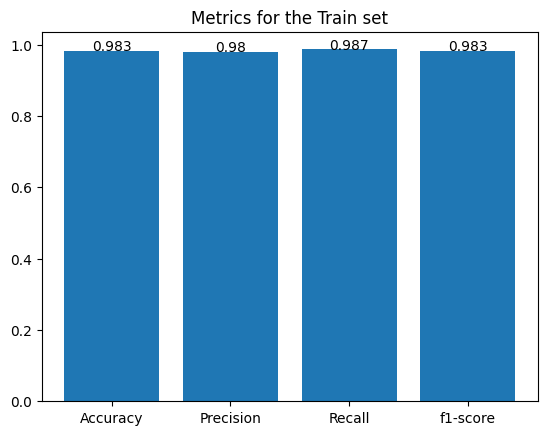

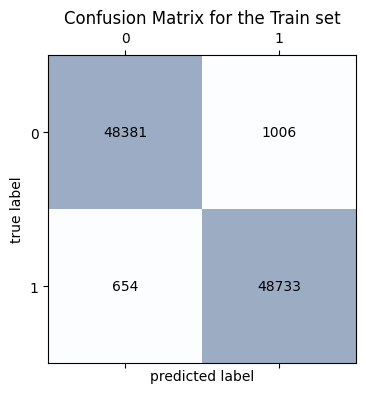

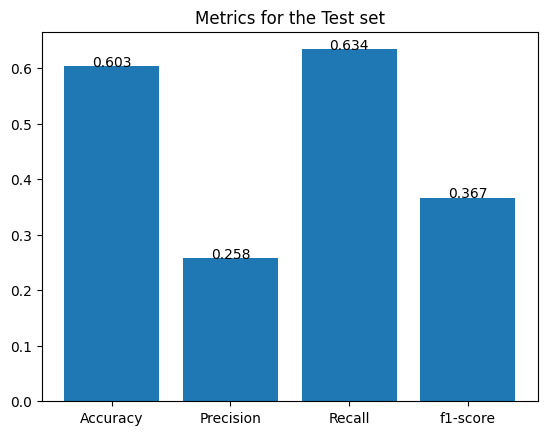

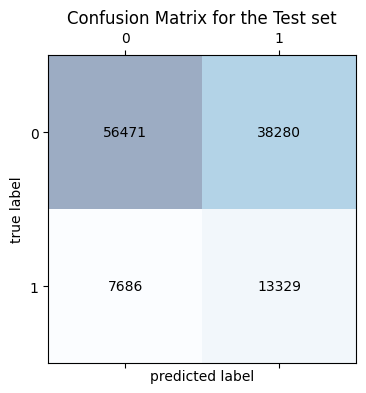

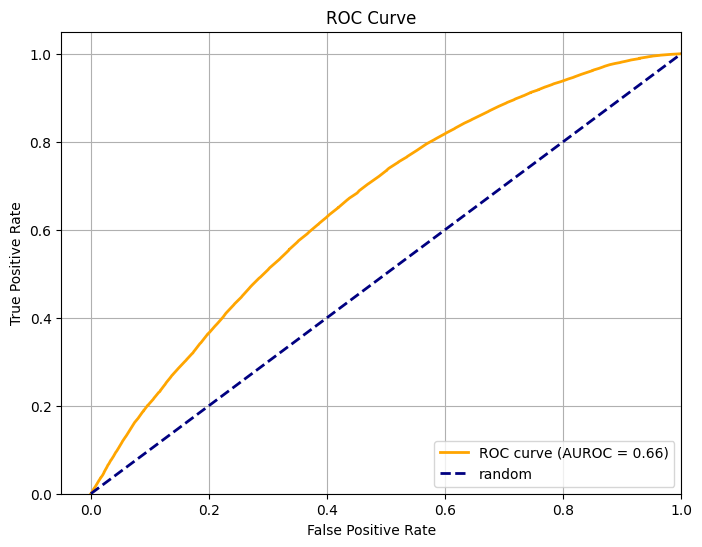

In [21]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

Recall requirement: (False, 0.6342612419700214)


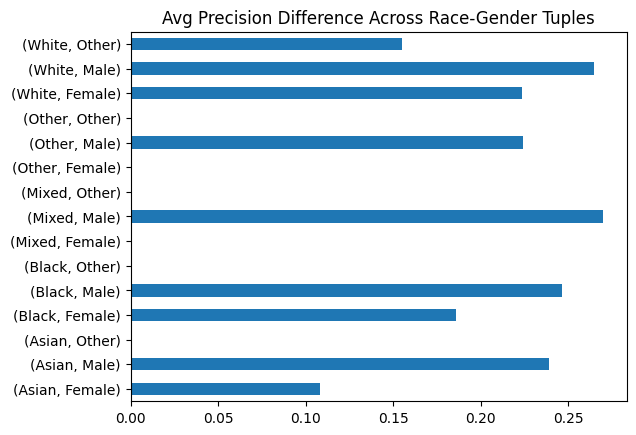

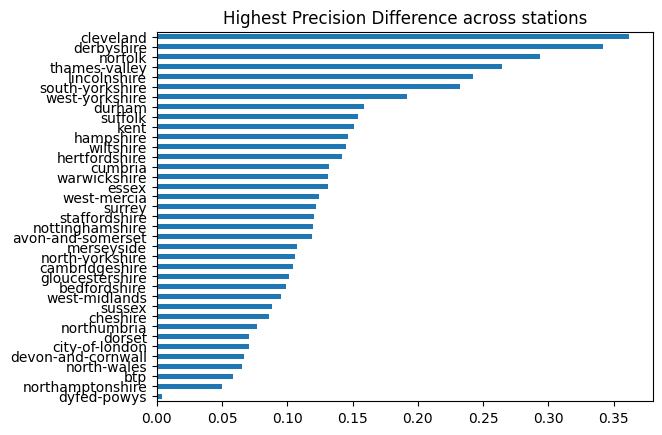

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.2648805760991097, ('White', 'Female'): 0.2238130679170018, ('White', 'Other'): 0.15476190476190477, ('Black', 'Male'): 0.24648569741620246, ('Black', 'Female'): 0.1859724828289888, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.23905442139349425, ('Asian', 'Female'): 0.10833333333333334, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2699683892517153, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.22409161201087768, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 35
Num good departments: 2
avg diff: 0.13716756756756757


In [22]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [23]:
model = GradientBoostingClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.60602357 0.60332847 0.6019476  0.60083196 0.60484155]


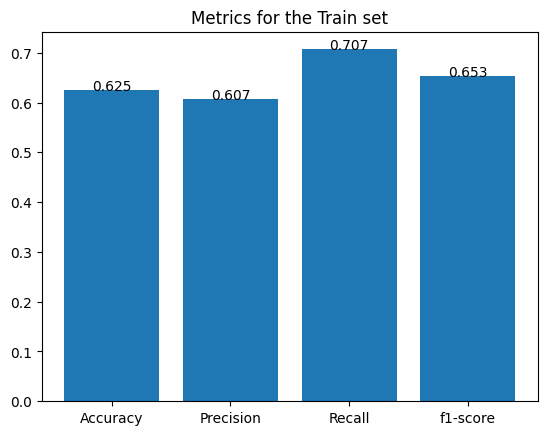

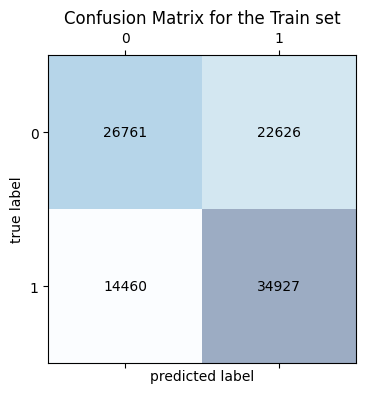

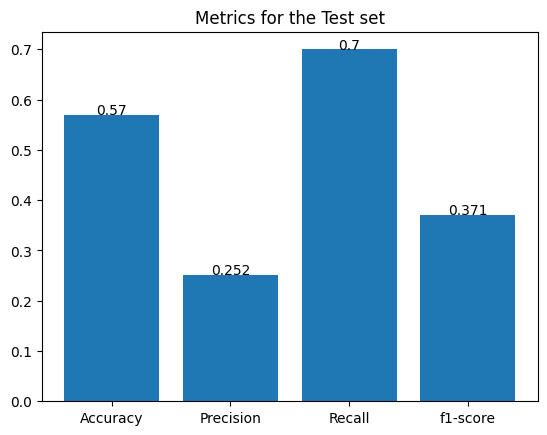

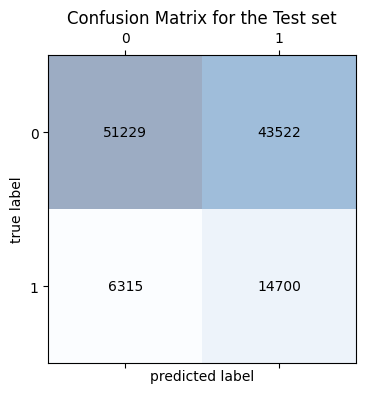

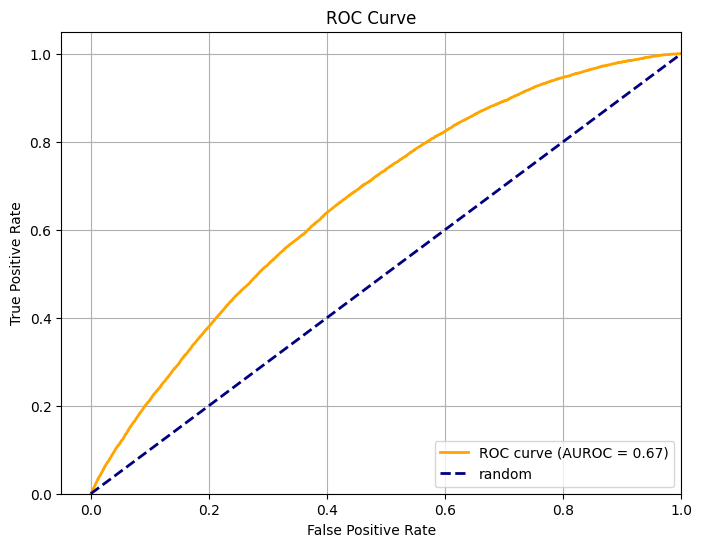

In [24]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

Recall requirement: (False, 0.6995003568879372)


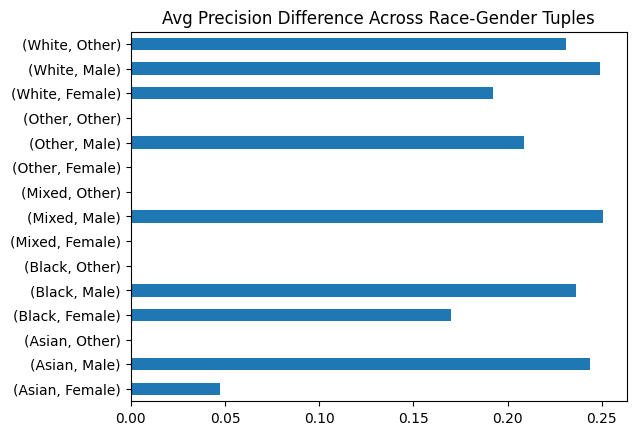

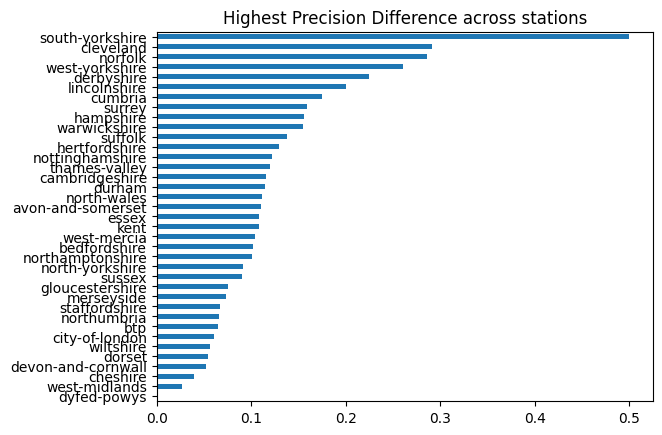

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.24914487972514548, ('White', 'Female'): 0.19239408538318606, ('White', 'Other'): 0.23072562358276644, ('Black', 'Male'): 0.23636877582507757, ('Black', 'Female'): 0.17000070665674838, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.24370989827857714, ('Asian', 'Female'): 0.0472972972972973, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2506571352048111, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.20870546176511148, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.1272789189189189


In [25]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Train Best Model

The best model seems to be: Naive Bayes
It was less prone to overfit while still having a decent value of Precision, Recall and AUROC.


In [26]:
model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56202155 0.56313424 0.56422605 0.56129552 0.56429156]


In [27]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

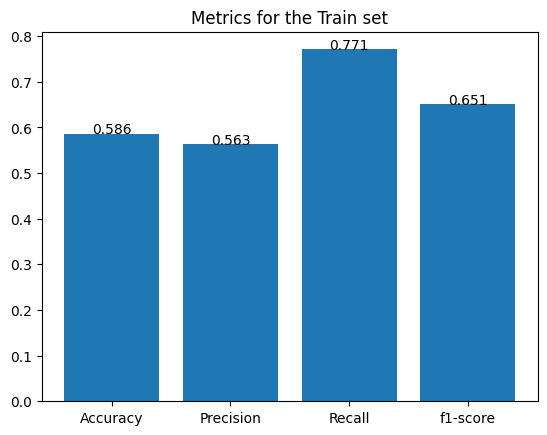

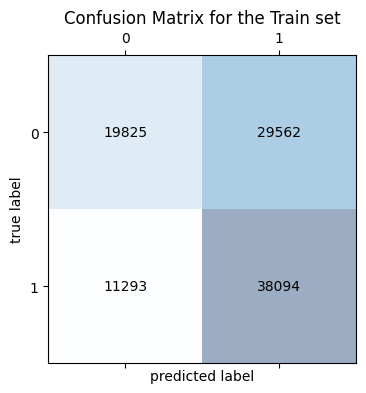

In [28]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

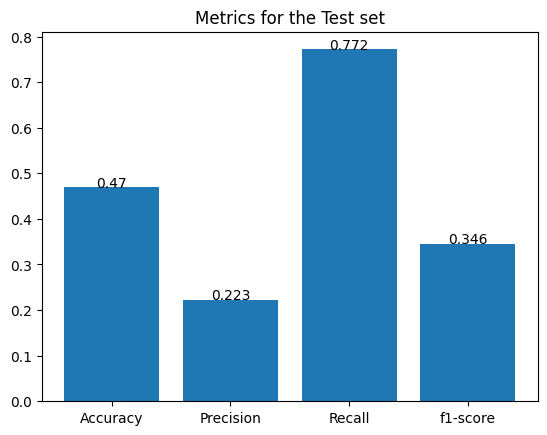

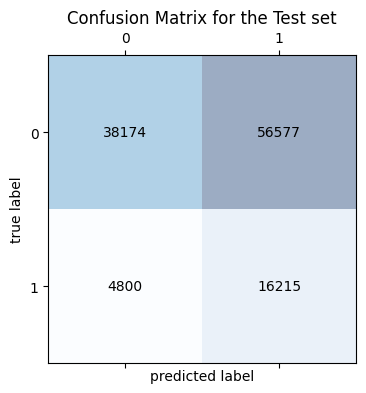

In [29]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

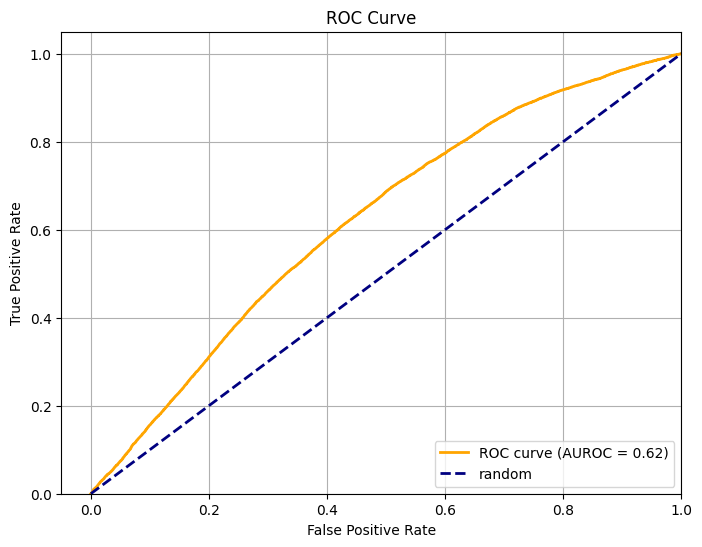

In [30]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.6995003568879372)


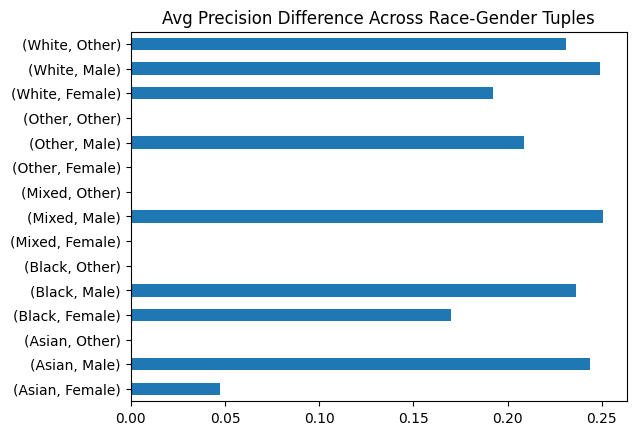

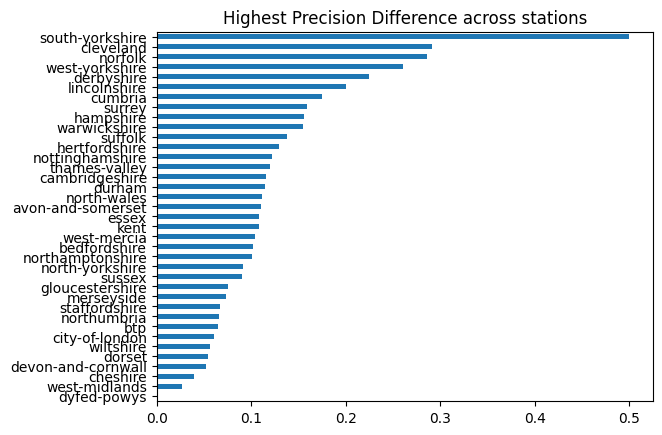

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.24914487972514548, ('White', 'Female'): 0.19239408538318606, ('White', 'Other'): 0.23072562358276644, ('Black', 'Male'): 0.23636877582507757, ('Black', 'Female'): 0.17000070665674838, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.24370989827857714, ('Asian', 'Female'): 0.0472972972972973, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2506571352048111, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.20870546176511148, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.1272789189189189


In [31]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")